Dataset:

The dataset has the following columns:

* tweet_id                                                           
*   airline_sentiment                                               
* airline_sentiment_confidence                               
* negativereason                                                  
* negativereason_confidence                                    
* airline                                                                    
* airline_sentiment_gold                                              
* name     
* negativereason_gold 
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location 
* user_timezone


#  Import the libraries

In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary libraries.
import re, string, unicodedata
import nltk                                   # Natural language processing tool-kit

!pip install contractions
import contractions


from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from collections import Counter

In [377]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#load dataset

In [378]:
fl = r"/content/drive/MyDrive/Tweet/Tweets.csv"

In [379]:
tweet=pd.read_csv(fl)

In [380]:
tweet.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7233,569857331284078592,negative,0.7007,Can't Tell,0.3647,Delta,NaN,SL_024,NaN,0,@JetBlue yeah I'm aware of that. Hence my orig...,NaN,2015-02-23 05:52:29 -0800,NaN,Eastern Time (US & Canada)
11054,568561877699182592,neutral,0.6769,NaN,0.0000,US Airways,NaN,sstevenssss,NaN,0,@USAirways Have a 6:05pm flight out of PHL Sat...,NaN,2015-02-19 16:04:49 -0800,NaN,Eastern Time (US & Canada)
1071,569936640669581313,positive,1.0000,NaN,NaN,United,NaN,koploperfan1992,NaN,0,@united look at this beauty 😉 dc 10 united air...,"[51.322819, 5.3576218]",2015-02-23 11:07:38 -0800,Winterfell,NaN
13016,569959631256051712,negative,1.0000,Customer Service Issue,1.0000,American,NaN,avaflav13,NaN,0,@AmericanAir I had to purchase a ticket that I...,NaN,2015-02-23 12:39:00 -0800,NaN,Quito
1038,569956192111316992,negative,1.0000,Late Flight,1.0000,United,NaN,nfranco,NaN,0,@united 20 min more delays to flt 2086 at sfo ...,NaN,2015-02-23 12:25:20 -0800,NaN,Pacific Time (US & Canada)
1948,569507197052260354,neutral,1.0000,NaN,NaN,United,NaN,Angry_VBK,NaN,0,@united question. Are departure times based of...,NaN,2015-02-22 06:41:11 -0800,NaN,NaN
11112,568496861797076992,negative,1.0000,Customer Service Issue,0.6786,US Airways,NaN,JimmyisAble,NaN,1,@USAirways so basically I am stuck paying for ...,"[29.99562368, -90.24376862]",2015-02-19 11:46:28 -0800,NaN,Hawaii
5794,568590782640164865,negative,1.0000,Bad Flight,0.6882,Southwest,NaN,freehighfives,NaN,0,@SouthwestAir Paid for in flight wifi from Aus...,NaN,2015-02-19 17:59:41 -0800,"Austin, TX",Central Time (US & Canada)
6474,567829387485130752,positive,1.0000,NaN,NaN,Southwest,NaN,MeredithAdams23,NaN,0,@SouthwestAir Awesome - thanks!,NaN,2015-02-17 15:34:10 -0800,Dallas,Central Time (US & Canada)
10207,569489753332191232,negative,1.0000,Lost Luggage,0.6871,US Airways,NaN,WarrickHoward,NaN,0,@USAirways My bags were supposed to be deliver...,NaN,2015-02-22 05:31:52 -0800,NaN,London


#print shape of data

In [381]:
print("There are {} rows and {} columns in the dataset" .format(tweet.shape[0], tweet.shape[1]))

There are 14640 rows and 15 columns in the dataset


#EDA from pre-processing

In [382]:
pd.DataFrame(tweet['airline_sentiment'].value_counts())

,airline_sentiment
negative,9178
neutral,3099
positive,2363


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


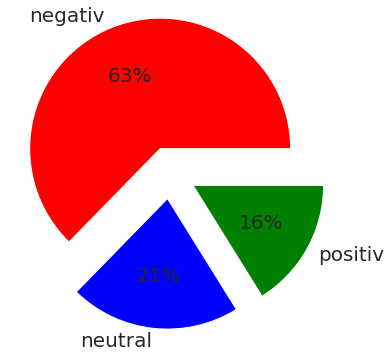

In [383]:
# labels=pd.DataFrame(tweet['airline_sentiment'].value_counts().index)
labels=['negativ',  'neutral','positiv']
x=tweet['airline_sentiment'].value_counts()
fig, ax = plt.subplots(figsize=(6,6))
fig.figsize=(20,20)
exp=[0.2,0.2,0.2]
col=['red','blue','green']
ax.pie(x,autopct='%.0f%%', labels=labels, explode=exp, colors=col, textprops={'fontsize':20})
print(x)


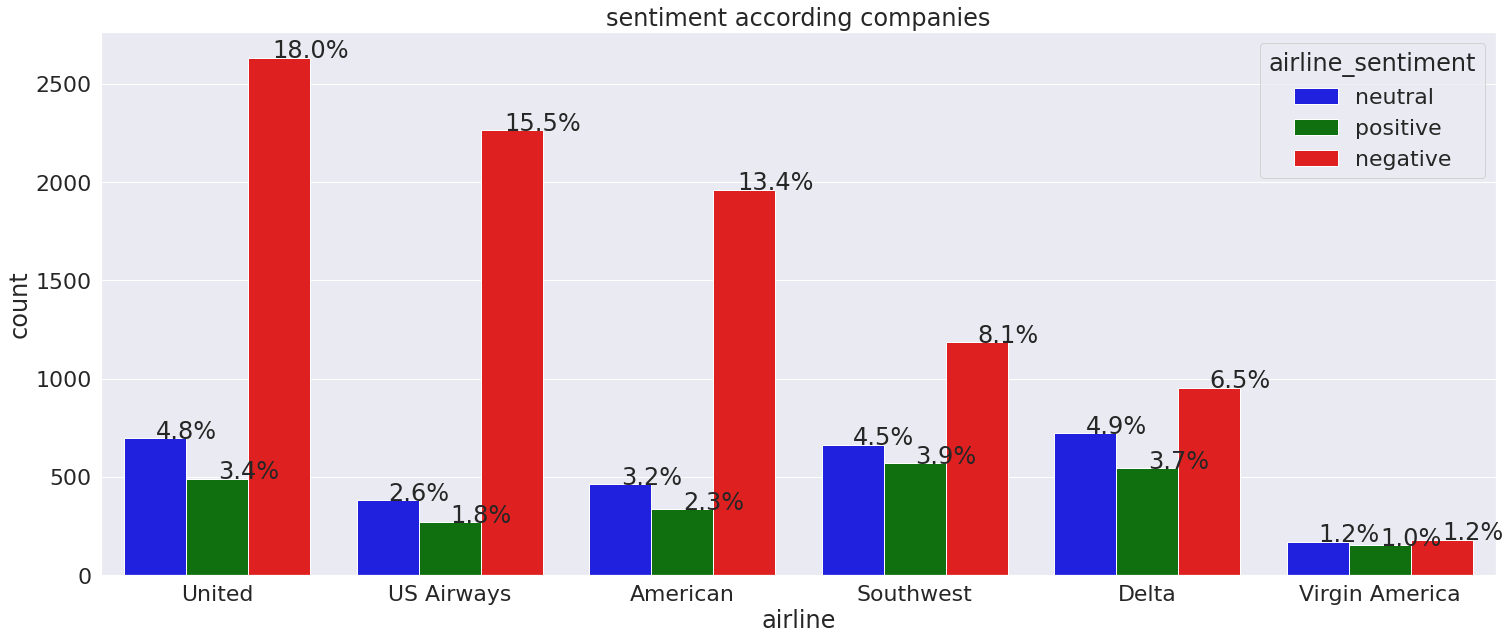

In [384]:

plt.figure(figsize=(25,10))
sns.set(font_scale=2)
ax=sns.countplot(data=tweet,x=tweet['airline'], order=tweet['airline'].value_counts().index,hue=tweet['airline_sentiment'],palette={'neutral':'blue', 'positive':'green', 'negative':'red'})
ax.set_title("sentiment according companies")
total = float(len(tweet['airline']))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
    

plt.show()


In [385]:
tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

**The most common words from the text column**


---


In [386]:
tweet['text'] = tweet.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
top = Counter([item for sublist in tweet['text'] for item in sublist])
freq = pd.DataFrame(top.most_common(20))
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Reds')

,Common_words,count
0,@,16583
1,.,13610
2,to,8589
3,I,6347
4,the,5796
5,!,5312
6,?,4678
7,a,4364
8,",",4156
9,for,3953


#Drop all other columns except “text” and “airline_sentiment”

In [387]:
for i in enumerate(tweet.columns):
  if i[1]!='airline_sentiment' and i[1]!='text':
    tweet.drop(i[1],axis=1, inplace=True)

In [388]:
tweet.sample(3)

,airline_sentiment,text
2512,neutral,"[@, united, Hi, have, a, question, re, future,..."
8195,neutral,"[@, JetBlue, I, 'm, so, ready, to, see, N598JB..."
12788,negative,"[@, AmericanAir, I, have, got, a, flight, for,..."


#print shape of data

In [389]:
print("There are {} rows and {} columns in the dataset" .format(tweet.shape[0], tweet.shape[1]))

There are 14640 rows and 2 columns in the dataset


#data description

In [390]:
tweet.describe().T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
text,14640,14423,"[@, united, thanks]",6


#Print the first 5 rows of data

In [391]:
tweet.head(5)

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big..."


#Missing value analysis

In [392]:
tweet.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

*there are no missing values*

In [393]:
tweet.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big..."


#check shape of the data

In [394]:
print("There are {} rows and {} columns in the dataset" .format(tweet.shape[0], tweet.shape[1]))

There are 14640 rows and 2 columns in the dataset


#Data Pre - Processing


* Html tag removal
* Remove the numbers
* Tokenization
* Removal of Special Characters and Punctuations
* Removal of stopwords
* Conversion to lowercase
* Lemmatize
* Remove non-ascii character
* Join the words in the list to convert back to text string in the data frame

#text column as text type

In [396]:
def join_to_text(t):
        return ' '.join(map(str, t))

tweet['text'] = [join_to_text(t) for t in tweet['text']]

**remove html tags using regular expressions**

---



In [397]:
for i, row in tweet.iterrows():
    clean_tweet = re.sub(r"http\S+", "", tweet.at[i, 'text'])
    tweet.at[i,'text'] = clean_tweet
tweet.head()

,airline_sentiment,text
0,neutral,@ VirginAmerica What @ dhepburn said .
1,positive,@ VirginAmerica plus you 've added commercials...
2,neutral,@ VirginAmerica I did n't today ... Must mean ...
3,negative,@ VirginAmerica it 's really aggressive to bla...
4,negative,@ VirginAmerica and it 's a really big bad thi...


**remove numbers**


---


In [398]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweet['text'] = tweet['text'].apply(lambda x: remove_numbers(x))
tweet.head()

,airline_sentiment,text
0,neutral,@ VirginAmerica What @ dhepburn said .
1,positive,@ VirginAmerica plus you 've added commercials...
2,neutral,@ VirginAmerica I did n't today ... Must mean ...
3,negative,@ VirginAmerica it 's really aggressive to bla...
4,negative,@ VirginAmerica and it 's a really big bad thi...


**tokenization**

---

In [399]:
nltk.download('punkt')
tweet['text'] = tweet.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
tweet.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big..."


**Removal of Special Characters and Punctuations**


---



In [400]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

In [401]:
tweet['text'] = tweet['text'].apply(lambda x: remove_punctuation(x))
tweet.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, ve, added, commerci..."
2,neutral,"[VirginAmerica, I, did, nt, today, Must, mean,..."
3,negative,"[VirginAmerica, it, s, really, aggressive, to,..."
4,negative,"[VirginAmerica, and, it, s, a, really, big, ba..."


**Removal of stopwords**


---



In [402]:
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [403]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

In [404]:
tweet['text'] = tweet['text'].apply(lambda x: remove_stopwords(x))
tweet.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, added, commercials, expe..."
2,neutral,"[VirginAmerica, I, nt, today, Must, mean, I, n..."
3,negative,"[VirginAmerica, really, aggressive, blast, obn..."
4,negative,"[VirginAmerica, really, big, bad, thing]"


**Coversation to lowercase**



---



In [405]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [406]:
tweet['text'] = tweet['text'].apply(lambda x: to_lowercase(x))
tweet.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercials, expe..."
2,neutral,"[virginamerica, i, nt, today, must, mean, i, n..."
3,negative,"[virginamerica, really, aggressive, blast, obn..."
4,negative,"[virginamerica, really, big, bad, thing]"


**lemmatize the words in the text**


---


In [407]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [408]:
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

tweet['text'] = tweet['text'].apply(lambda x: lemmatize_list(x))
tweet.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercial, exper..."
2,neutral,"[virginamerica, i, nt, today, must, mean, i, n..."
3,negative,"[virginamerica, really, aggressive, blast, obn..."
4,negative,"[virginamerica, really, big, bad, thing]"


**Remove non-ascii character**


---



In [409]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [410]:
tweet['text'] = tweet['text'].apply(lambda x: remove_non_ascii(x))
tweet.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercial, exper..."
2,neutral,"[virginamerica, i, nt, today, must, mean, i, n..."
3,negative,"[virginamerica, really, aggressive, blast, obn..."
4,negative,"[virginamerica, really, big, bad, thing]"


**Join the words in the list to convert back to text string in the data frame**

---

In [411]:
tweet['text']

0                    [virginamerica, what, dhepburn, said]
1        [virginamerica, plus, added, commercial, exper...
2        [virginamerica, i, nt, today, must, mean, i, n...
3        [virginamerica, really, aggressive, blast, obn...
4                 [virginamerica, really, big, bad, thing]
                               ...                        
14635    [americanair, thank, got, different, flight, c...
14636    [americanair, leaving, minute, late, flight, n...
14637    [americanair, please, bring, american, airline...
14638    [americanair, money, change, flight, nt, answe...
14639    [americanair, ppl, need, know, many, seat, nex...
Name: text, Length: 14640, dtype: object

In [412]:
def join_to_text(t):
        return ' '.join(map(str, t))

tweet['text'] = [join_to_text(t) for t in tweet['text']]

In [413]:
for i in range(0,len(tweet['text'])):
  tweet['text'][i]=str(tweet['text'][i])

**Print the first 5 rows of data after pre-processing**

---

In [414]:
tweet.head(5)

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus added commercial experience...
2,neutral,virginamerica i nt today must mean i need take...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


In [415]:
tweet.shape


(14640, 2)

#Vectorization

**Apply count vectorizer**

---

##convert list to string

In [416]:
tweet.shape

(14640, 2)

In [417]:
tweet['text']

0                         virginamerica what dhepburn said
1        virginamerica plus added commercial experience...
2        virginamerica i nt today must mean i need take...
3        virginamerica really aggressive blast obnoxiou...
4                       virginamerica really big bad thing
                               ...                        
14635       americanair thank got different flight chicago
14636    americanair leaving minute late flight no warn...
14637    americanair please bring american airline blac...
14638    americanair money change flight nt answer phon...
14639    americanair ppl need know many seat next fligh...
Name: text, Length: 14640, dtype: object

In [418]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()
vectorizer.fit(tweet['text'])
print(vectorizer.vocabulary_)
vector_cv=vectorizer.transform(tweet['text'])
print(vector_cv.shape)
print(type(vector_cv))
vector_cv_arr=vector_cv.toarray()
print(vector_cv_arr)

{'virginamerica': 12358, 'what': 12597, 'dhepburn': 2791, 'said': 8952, 'plus': 7874, 'added': 148, 'commercial': 2037, 'experience': 3573, 'tacky': 10122, 'nt': 7176, 'today': 11676, 'must': 6791, 'mean': 6410, 'need': 6886, 'take': 10134, 'another': 500, 'trip': 11840, 'really': 8366, 'aggressive': 231, 'blast': 1146, 'obnoxious': 7218, 'entertainment': 3367, 'guest': 4535, 'face': 3629, 'amp': 433, 'little': 6019, 'recourse': 8423, 'big': 1093, 'bad': 858, 'thing': 11526, 'seriously': 9201, 'would': 12810, 'pay': 7627, 'flight': 3872, 'seat': 9113, 'playing': 7838, 'flying': 3965, 'va': 12256, 'yes': 12916, 'nearly': 6883, 'every': 3474, 'time': 11619, 'fly': 3952, 'vx': 12408, 'ear': 3163, 'worm': 12782, 'go': 4370, 'away': 813, 'missed': 6612, 'prime': 8077, 'opportunity': 7352, 'men': 6470, 'without': 12719, 'hat': 4639, 'parody': 7563, 'tcomwpggrezp': 10773, 'well': 12558, 'didntbut': 2807, 'now': 7162, 'do': 2987, 'amazing': 392, 'arrived': 638, 'hour': 4912, 'early': 3166, 'yo

**Tf-IDF vectorizer**

---

In [419]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(tweet['text'])
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector_tf = vectorizer.transform(tweet['text'])
# summarize encoded vector
print(vector_tf.shape)
vector_tf_arr=vector_tf.toarray()
print(vector_tf_arr)

{'virginamerica': 12358, 'what': 12597, 'dhepburn': 2791, 'said': 8952, 'plus': 7874, 'added': 148, 'commercial': 2037, 'experience': 3573, 'tacky': 10122, 'nt': 7176, 'today': 11676, 'must': 6791, 'mean': 6410, 'need': 6886, 'take': 10134, 'another': 500, 'trip': 11840, 'really': 8366, 'aggressive': 231, 'blast': 1146, 'obnoxious': 7218, 'entertainment': 3367, 'guest': 4535, 'face': 3629, 'amp': 433, 'little': 6019, 'recourse': 8423, 'big': 1093, 'bad': 858, 'thing': 11526, 'seriously': 9201, 'would': 12810, 'pay': 7627, 'flight': 3872, 'seat': 9113, 'playing': 7838, 'flying': 3965, 'va': 12256, 'yes': 12916, 'nearly': 6883, 'every': 3474, 'time': 11619, 'fly': 3952, 'vx': 12408, 'ear': 3163, 'worm': 12782, 'go': 4370, 'away': 813, 'missed': 6612, 'prime': 8077, 'opportunity': 7352, 'men': 6470, 'without': 12719, 'hat': 4639, 'parody': 7563, 'tcomwpggrezp': 10773, 'well': 12558, 'didntbut': 2807, 'now': 7162, 'do': 2987, 'amazing': 392, 'arrived': 638, 'hour': 4912, 'early': 3166, 'yo

#Fit and evaluate the model using both types of vectorization.


###encoding with dictionnary

In [420]:
dict={'neutral':0, 'positive':1, 'negative':2}

tweet['airline_sentiment']=tweet['airline_sentiment'].replace(dict)

In [421]:
tweet

,airline_sentiment,text
0,0,virginamerica what dhepburn said
1,1,virginamerica plus added commercial experience...
2,0,virginamerica i nt today must mean i need take...
3,2,virginamerica really aggressive blast obnoxiou...
4,2,virginamerica really big bad thing
...,...,...
14635,1,americanair thank got different flight chicago
14636,2,americanair leaving minute late flight no warn...
14637,0,americanair please bring american airline blac...
14638,2,americanair money change flight nt answer phon...



<strong>
<ol>
<li>Neutral sentiment --> 0
<li>Positive sentiment --> 1
<li>Negative sentiment --> 2
</ol>
</strong>

**Countvectorizer**

---

#Train test split

In [422]:
from sklearn.model_selection import train_test_split
labels=tweet['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(vector_cv_arr, labels, test_size=0.3, random_state=1, stratify=labels)

##confusion matrix

In [423]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=-1)

forest = forest.fit(X_train, y_train)

y_predict=forest.predict(X_test)

print(forest)

print(np.mean(cross_val_score(forest, vector_cv_arr, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7084699453551913


Text(92.5, 0.5, 'True Label')

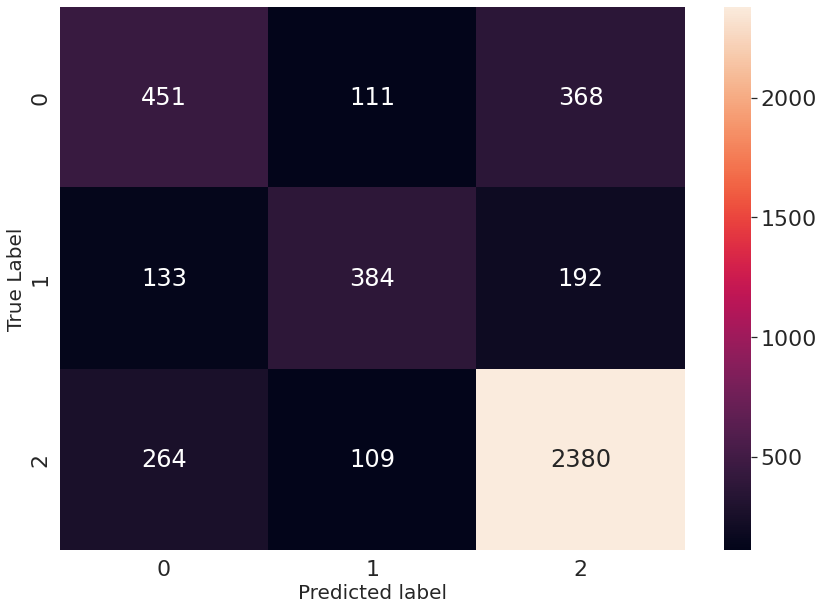

In [424]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(14,10))
p=sns.heatmap(confusion_matrix(y_test, y_predict, labels=[0,1,2]), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)

**Conclusion of the Count vectorizer:**



*   0 neutral predicted True: 470 --> 53% 451/(451+133+264)
*  1 positive predicted True: 399 --> 64% 384/(384+111+109)
* 2 negative predicted True: 2373 --> 81% 2380/(2380+192+368)

**TfIdf vectorizer**

---

In [425]:
from sklearn.model_selection import train_test_split
labels=tweet['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(vector_tf_arr, labels, test_size=0.3, random_state=1, stratify=labels)

In [426]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=-1)

forest = forest.fit(X_train, y_train)
y_predict=forest.predict(X_test)
print(forest)

print(np.mean(cross_val_score(forest, vector_tf_arr, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7042349726775956


Text(92.5, 0.5, 'True Label')

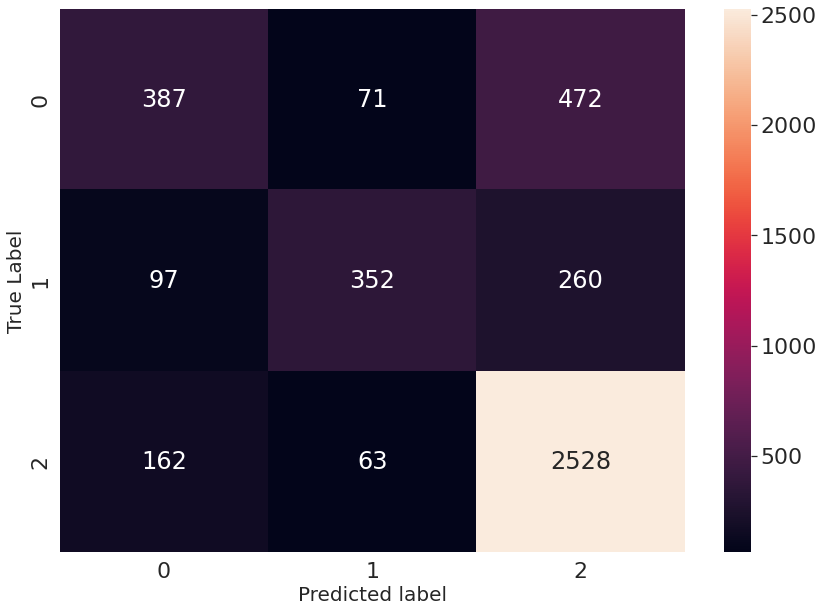

In [427]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(14,10))
p=sns.heatmap(confusion_matrix(y_test, y_predict, labels=[0,1,2]), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)

**Conclusion of the TfIdf vectirizer:**



*   0 neutral predicted True: 409 --> 60% 387/(387+97+162)
*  1 positive predicted True: 353 --> 73% 352/(352+71+63)
* 2 negative predicted True: 2512 --> 78% 2528/(2528+260+472)




#Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset

**For the NLP process pre processing steps are needed:**

* **Html tag removal:** delete all the HTML tags, signs from the text are used in the HTML editor
* **Remove the numbers:** remove number format characters from the text they dont have any additional meaning
* **Tokenization:** split the text small parts (tokens) for a better computational understanding
* **Removal of Special Characters and Punctuations:** removal of pecial characters from the text they have no useful role int he text
* **Removal of stopwords:** remove stopwords listed in nltk package 
* **Conversion to lowercase:** reduce the distinct words in the text with removing Upper letters
* **Lemmatize:** inflected forms are groupped together for the better analysis
* **Remove non-ascii character:** remove characters they are strange for the current code of text
* **Join the words in the list to convert back to text string in the data frame** : join the words together for building a text for each rows

**Summary of unterstanding Vectorization and performance of the model on the dataset:**


*   **Count vectorization**: returns float, the result of the vectorizer is a frequency representation, focus only of the frequency of the words
  * PERFORMANCE: 70.69%

*   **TF IDf vectorization**: Term Frequency - Inverse Document Frequency, brought a little bit better summarized result as another vectorizer, returns integer, focus not only the frequency of the words, provides an importance of the words
  * PERFORMANCE: 71.17%

